<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/c620_transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
import joblib
!pip install autorch > log.txt

In [14]:
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c620_col_names.pkl')
c620_df = pd.read_excel('/content/drive/MyDrive/台塑輕油案子/data/c620/明志_遷移式學習_訓練資料_寄送版/c620_data.xlsx',index_col=0)
print(c620_df.shape)
c620_df.head(3)

(168, 218)


,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",...,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Methylcyclohexane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Toluene_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Octane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Propylcyclopentane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Ethylcyclohexane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Eth

# 缺失欄位

In [15]:
miss_col = c620_df.columns[(c620_df.isnull().sum() > 0).values].tolist()
print(len(miss_col))
miss_col

2


['Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr',
 'Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr']

# 有提供欄位

In [16]:
have_col = c620_df.columns[(c620_df.isnull().sum() == 0).values].tolist()
print(len(have_col))
have_col

216


['Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC',
 'Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr',
 'Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%',
 'Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%',
 'Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%',
 'Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%',
 'Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%',
 'Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%',
 'Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%',
 'Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%',
 'Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%',
 'Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%',
 'Combined Feed to Tatoray Stripper C620_Detailed Composition_n-H

# 補足缺失欄位 分離係數

In [17]:
path = '/content/drive/MyDrive/台塑輕油案子/data/c620/明志_遷移式學習_訓練資料_寄送版/蒸餾塔(C620_C660_C670)取出品管資料_寄送明志科大 r2.xlsx'
df2 = pd.read_excel(path,sheet_name='資料彙整(寄送明志)r2')
df2.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,...,Unnamed: 130,Unnamed: 131,Unnamed: 132,Unnamed: 133,Unnamed: 134,Unnamed: 135,Unnamed: 136,Unnamed: 137,Unnamed: 138,Unnamed: 139,Unnamed: 140,Unnamed: 141,Unnamed: 142,Unnamed: 143,Unnamed: 144,Unnamed: 145,Unnamed: 146,Unnamed: 147,Unnamed: 148,Unnamed: 149,Unnamed: 150,Unnamed: 151,Unnamed: 152,Unnamed: 153,Unnamed: 154,Unnamed: 155,Unnamed: 156,Unnamed: 157,Unnamed: 158,Unnamed: 159,Unnamed: 160,Unnamed: 161,Unnamed: 162,Unnamed: 163,Unnamed: 164,Unnamed: 165,Unnamed: 166,Unnamed: 167,Unnamed: 168,Unnamed: 169
0,NaN,C620_Vent_Gas,2020-09-02 00:00:00,2020-09-03 00:00:00,2020-09-04 00:00:00,2020-09-05 00:00:00,2020-09-06 00:00:00,2020-09-07 00:00:00,2020-09-08 00:00:00,2020-09-09 00:00:00,2020-09-10 00:00:00,2020-09-11 00:00:00,2020-09-12 00:00:00,2020-09-13 00:00:00,2020-09-14 00:00:00,2020-09-15 00:00:00,2020-09-16 00:00:00,2020-09-17 00:00:00,2020-09-18 00:00:00,2020-09-19 00:00:00,2020-09-20 00:00:00,2020-09-21 00:00:00,2020-09-22 00:00:00,2020-09-23 00:00:00,2020-09-24 00:00:00,2020-09-25 00:00:00,2020-09-26 00:00:00,2020-09-27 00:00:00,2020-09-28 00:00:00,2020-09-29 00:00:00,2020-09-30 00:00:00,2020-10-02 00:00:00,2020-10-03 00:00:00,2020-10-04 00:00:00,2020-10-05 00:00:00,2020-10-06 00:00:00,2020-10-07 00:00:00,2020-10-08 00:00:00,2020-10-09 00:00:00,2020-10-10 00:00:00,...,2021-01-12 00:00:00,2021-01-13 00:00:00,2021-01-14 00:00:00,2021-01-15 00:00:00,2021-01-16 00:00:00,2021-01-17 00:00:00,2021-01-18 00:00:00,2021-01-19 00:00:00,2021-01-20 00:00:00,2021-01-21 00:00:00,2021-01-22 00:00:00,2021-01-23 00:00:00,2021-01-24 00:00:00,2021-01-25 00:00:00,2021-01-26 00:00:00,2021-01-27 00:00:00,2021-01-28 00:00:00,2021-01-29 00:00:00,2021-01-30 00:00:00,2021-01-31 00:00:00,2021-02-02 00:00:00,2021-02-03 00:00:00,2021-02-04 00:00:00,2021-02-05 00:00:00,2021-02-06 00:00:00,2021-02-07 00:00:00,2021-02-08 00:00:00,2021-02-09 00:00:00,2021-02-10 00:00:00,2021-02-11 00:00:00,2021-02-12 00:00:00,2021-02-13 00:00:00,2021-02-14 00:00:00,2021-02-15 00:00:00,2021-02-16 00:00:00,2021-02-17 00:00:00,2021-02-18 00:00:00,2021-02-19 00:00:00,2021-02-20 00:00:00,2021-02-21 00:00:00
1,NaN,Hydrogen,6.531,8.41,7.918,7.8752,7.372,7.59,7.431,7.115,7.37,6.78,7.96,7.79,8.21,8.1288,7.6925,8.1227,8.8135,7.6956,8.041,7.907,7.394,7.774,8.159,7.22,7.184,6.901,7.151,7.39,7.18,8.86,8.1,8.5,8.0328,11.008,8.0358,10.241,30.628,36.404,...,9.56,8.6134,8.5596,4.7681,9.9246,8.5458,8.902,6.704,8.496,8.01,8.815,7.868,7.988,8.315,8.65,7.809,7.81,9.12,8.72,9.45,9.6649,9.0969,8.6988,3.6305,9.3991,9.107,8.271,7.902,8.084,7.941,7.491,8.036,7.967,7.65,7.99,7.63,8.47,9.25,9.86,9.61
2,NaN,Methane,1.898,2.229,2.343,2.453,2.384,2.414,2.371,2.316,2.36,2.31,2.57,2.41,2.53,2.5528,2.4797,2.5428,2.7001,2.3819,2.399,2.298,2.315,2.163,2.212,2.322,2.296,2.21,2.256,2.233,2.22,2.48,2.45,2.51,2.3331,2.8984,2.2278,2.3713,3.0879,3.642,...,3,2.8436,2.7739,1.4418,2.4487,2.8594,2.776,2.384,2.798,2.711,2.964,2.742,2.694,2.824,3.031,3.173,3.17,3.21,3.09,3.22,3.3915,3.1516,3.2169,1.6245,3.4361,3.168,2.982,2.973,2.901,2.872,2.701,2.911,2.934,2.93,2.926,2.83,2.99,3.27,2.83,3.46
3,NaN,Ethane,35.025,38.57,37.649,37.257,38.169,37.37,37.082,37.207,37.17,37.19,38.94,38.94,39.6,39.391,39.359,40.237,39.285,36.894,37.034,36.761,37.409,36.568,36.671,37.315,36.726,37.814,37.294,37.049,38.11,34.88,35.12,34.83,34.477,38.151,31.911,35.016,28.548,30.702,...,38.32,36.366,32.599,25.409,34.855,35.881,34.237,31.999,32.443,33.041,34.721,32.939,33.654,34.075,35.408,37.122,37.12,35.29,35.12,34.86,33.974,32.74,33.978,29.971,34.754,33.463,32.24,32.04,

In [18]:
c.keys()

dict_keys(['x41', 'case', 'yRefluxRate', 'yControl', 'yHeatDuty', 'vent_gas_x', 'distillate_x', 'sidedraw_x', 'bottoms_x', 'vent_gas_sf', 'distillate_sf', 'sidedraw_sf', 'bottoms_sf', 'density'])

In [19]:
c620_wt1,c620_fout1 = df2.iloc[1:1+41,2:].T,df2.iloc[[1+41],2:].T 
c620_wt2,c620_fout2 = df2.iloc[45:45+41,2:].T,df2.iloc[[45+41],2:].T  
c620_wt3,c620_fout3 = df2.iloc[89:89+41,2:].T,df2.iloc[[89+41],2:].T 
c620_wt4,c620_fout4 = df2.iloc[133:133+41,2:].T,df2.iloc[[133+41],2:].T
c620_feed_wt,c620_feed_flow = df2.iloc[441:441+41,2:].T,df2.iloc[[441+41],2:].T

c620_wt1.index = c620_df.index
c620_wt2.index = c620_df.index
c620_wt3.index = c620_df.index
c620_wt4.index = c620_df.index

c620_wt1.columns = c['vent_gas_x']
c620_wt2.columns = c['distillate_x']
c620_wt3.columns = c['sidedraw_x']
c620_wt4.columns = c['bottoms_x']

s1 = np.clip((c620_wt1.values*c620_fout1.values)/(c620_feed_wt.values*c620_feed_flow.values+1e-8),0,1)
s2 = np.clip((c620_wt2.values*c620_fout2.values)/(c620_feed_wt.values*c620_feed_flow.values+1e-8),0,1)
s3 = np.clip((c620_wt3.values*c620_fout3.values)/(c620_feed_wt.values*c620_feed_flow.values+1e-8),0,1)
s4 = np.clip((c620_wt4.values*c620_fout4.values)/(c620_feed_wt.values*c620_feed_flow.values+1e-8),0,1)

s1_col = c620_df.filter(regex='Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas').columns.tolist()
s2_col = c620_df.filter(regex='Split Factor for Individual Component to Tatoray Stripper C620 Distillate').columns.tolist()
s3_col = c620_df.filter(regex='Split Factor for Individual Component to Tatoray Stripper C620 Sidedraw').columns.tolist()
s4_col = c620_df.filter(regex='Split Factor for Individual Component to Tatoray Stripper C620 Bottoms').columns.tolist()

c620_df[s1_col] = s1
c620_df[s2_col] = s2
c620_df[s3_col] = s3
c620_df[s4_col] = s4

c620_wt_always_same_split_factor_dict = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c620_wt_always_same_split_factor_dict.pkl')
for i in c620_wt_always_same_split_factor_dict.keys():
  c620_df[i] = c620_wt_always_same_split_factor_dict[i]

c620_df = c620_df.join(c620_wt1).join(c620_wt2).join(c620_wt3).join(c620_wt4)
c620_df.to_excel('/content/drive/MyDrive/台塑輕油案子/data/c620/明志_遷移式學習_訓練資料_寄送版/c620_data.xlsx')

# 填補後重新讀取遷移學習數據

In [ ]:
c620_df = pd.read_excel('/content/drive/MyDrive/台塑輕油案子/data/c620/明志_遷移式學習_訓練資料_寄送版/c620_data.xlsx',index_col=0)
c620_df.head()

,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",...,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Methylcyclohexane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Toluene_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Octane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Propylcyclopentane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Ethylcyclohexane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Eth

# 欄位定義

In [ ]:
x_col = c['case']+c['x41']
op_col = c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']
sp_col = s1_col + s2_col + s3_col + s4_col
y_col = c620_df[sp_col+op_col].dropna(axis=1).columns.tolist()
n_idx = [ [i,i+41,i+41*2,i+41*3]for i in range(41)]

# 1. 實驗直接訓練 (不使用預訓練模型)

  3%|▎         | 10/300 [00:00<01:05,  4.44it/s]

epoch:0 train_loss:0.0874 valid_loss:0.0784


 23%|██▎       | 68/300 [00:01<00:08, 27.56it/s]

epoch:50 train_loss:0.0061 valid_loss:0.0083


 39%|███▉      | 118/300 [00:01<00:02, 66.16it/s]

epoch:100 train_loss:0.0053 valid_loss:0.0076


 56%|█████▋    | 169/300 [00:02<00:01, 90.05it/s]

epoch:150 train_loss:0.0047 valid_loss:0.0072


 70%|███████   | 210/300 [00:02<00:00, 90.30it/s]

epoch:200 train_loss:0.0041 valid_loss:0.0070


 86%|████████▋ | 259/300 [00:03<00:00, 65.22it/s]

epoch:250 train_loss:0.0034 valid_loss:0.0070


100%|██████████| 300/300 [00:03<00:00, 76.28it/s]


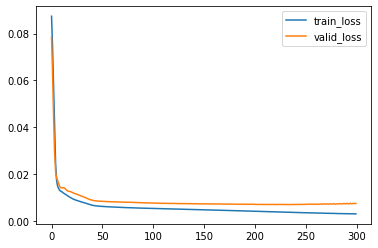

In [ ]:
from autorch.utils import PartBulider
c620 = PartBulider(c620_df,x_col,y_col,normalize_idx_list=n_idx,limit_y_range=True)
c620.train()

In [ ]:
c620.test(e=2e-2)

,R2,MSE,MAPE
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Hydrogen_Fraction,0,1.38693e-05,0.325375
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Methane_Fraction,0,0.0222218,14.2213
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Ethane_Fraction,0,0.192248,43.5757
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Propane_Fraction,0,0.254062,50.4045
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_n-Butane_Fraction,0,0.258009,50.7941
...,...,...,...
Density_Bottoms Production Rate and Composition,0.45602,4.78095e-07,0.071623
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0.353926,8.31165,2.21086
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0.627243,4.50944,1.09565
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0.821749,0.305881,0.242813


# 2.使用預訓練模型

2.1 用模擬數據先預訓練一個模型

  0%|          | 1/300 [00:00<03:12,  1.55it/s]

epoch:0 train_loss:0.0110 valid_loss:0.0026


 17%|█▋        | 51/300 [00:47<03:57,  1.05it/s]

epoch:50 train_loss:0.0002 valid_loss:0.0003


 34%|███▎      | 101/300 [01:34<03:10,  1.04it/s]

epoch:100 train_loss:0.0002 valid_loss:0.0002


 50%|█████     | 151/300 [02:25<02:35,  1.04s/it]

epoch:150 train_loss:0.0002 valid_loss:0.0002


 67%|██████▋   | 201/300 [03:20<01:55,  1.17s/it]

epoch:200 train_loss:0.0002 valid_loss:0.0002


 84%|████████▎ | 251/300 [04:23<01:03,  1.29s/it]

epoch:250 train_loss:0.0002 valid_loss:0.0002


100%|██████████| 300/300 [05:28<00:00,  1.10s/it]


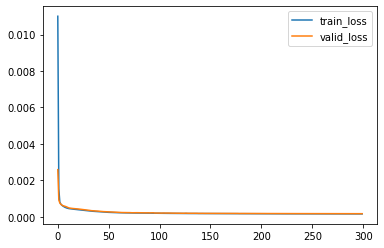

In [ ]:
c620_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_train.csv',index_col=0).dropna(axis=0)
c620 = PartBulider(c620_df,x_col,y_col,normalize_idx_list=n_idx,limit_y_range=True)
c620.train()

In [ ]:
c620.test(e=2e-2)

,R2,MSE,MAPE
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Hydrogen_Fraction,0,6.49388e-08,0.0120866
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Methane_Fraction,0.997491,5.68324e-08,0.0136754
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Ethane_Fraction,0.998564,7.90164e-07,0.0499916
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Propane_Fraction,0.999136,3.36415e-06,0.123624
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_n-Butane_Fraction,0.999461,9.2633e-06,0.268539
...,...,...,...
Density_Bottoms Production Rate and Composition,0.999813,3.08076e-12,0.000149929
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0.999101,0.124517,0.210302
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0.999704,0.000396083,0.00896085
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0.99964,0.000290686,0.00669049


2.2 把預訓練好的模型抽出來

In [ ]:
import copy
from copy import deepcopy
pretrain_net = deepcopy(c620.net)
pretrain_net

Sequential(
  (0): Linear(in_features=44, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=172, bias=True)
  (5): Sigmoid()
)

2.3 在預訓練模型上丟進真實資料繼續訓練

  6%|▌         | 18/300 [00:00<00:03, 84.75it/s]

epoch:0 train_loss:0.0031 valid_loss:0.0029


 21%|██▏       | 64/300 [00:00<00:02, 86.88it/s]

epoch:50 train_loss:0.0017 valid_loss:0.0023


 36%|███▋      | 109/300 [00:01<00:02, 86.84it/s]

epoch:100 train_loss:0.0014 valid_loss:0.0024


 54%|█████▍    | 163/300 [00:01<00:01, 85.60it/s]

epoch:150 train_loss:0.0012 valid_loss:0.0025


 72%|███████▏  | 217/300 [00:02<00:00, 85.12it/s]

epoch:200 train_loss:0.0010 valid_loss:0.0027


 87%|████████▋ | 262/300 [00:03<00:00, 84.69it/s]

epoch:250 train_loss:0.0009 valid_loss:0.0027


100%|██████████| 300/300 [00:03<00:00, 84.69it/s]


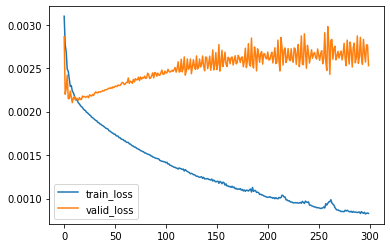

In [ ]:
from torch.optim import Adam
c620_df = pd.read_excel('/content/drive/MyDrive/台塑輕油案子/data/c620/明志_遷移式學習_訓練資料_寄送版/c620_data.xlsx',index_col=0)
c620 = PartBulider(c620_df,x_col,y_col,normalize_idx_list=n_idx,limit_y_range=True)
c620.net = pretrain_net
c620.optimizer = Adam(c620.net.parameters(),lr=0.001)
c620.train()

In [ ]:
c620.test(e=2e-2)

,R2,MSE,MAPE
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Hydrogen_Fraction,0,8.35933e-16,7.01231e-07
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Methane_Fraction,0,0.0157569,12.187
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Ethane_Fraction,0,0.170981,41.0638
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Propane_Fraction,0,0.253563,50.3549
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_n-Butane_Fraction,0,0.258031,50.7964
...,...,...,...
Density_Bottoms Production Rate and Composition,0.742574,1.53209e-07,0.0412902
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0.599297,10.6134,2.40928
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0.480211,6.85083,1.34211
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0,0.907211,0.297283


In [ ]:
c620.shrink()

In [ ]:
joblib.dump(c620,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_real_data.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_real_data.pkl']